# Setup

In [1]:
!python3 -m pip install --upgrade --quiet google-genai

In [2]:
# download images, image_editing_utils.py (helper fns)
!gcloud storage cp gs://qwiklabs-gcp-00-5ea23e119474-bucket/empty-bowl-on-empty-table.png .
!gcloud storage cp gs://qwiklabs-gcp-00-5ea23e119474-bucket/image_editing_utils.py .
!gcloud storage cp gs://qwiklabs-gcp-00-5ea23e119474-bucket/place-setting-mask.png .

Copying gs://qwiklabs-gcp-00-5ea23e119474-bucket/empty-bowl-on-empty-table.png to file://./empty-bowl-on-empty-table.png
  Completed files 1/1 | 1.4MiB/1.4MiB                                          

Average throughput: 108.8MiB/s
Copying gs://qwiklabs-gcp-00-5ea23e119474-bucket/image_editing_utils.py to file://./image_editing_utils.py
  Completed files 1/1 | 5.0kiB/5.0kiB                                          
Copying gs://qwiklabs-gcp-00-5ea23e119474-bucket/place-setting-mask.png to file://./place-setting-mask.png
  Completed files 1/1 | 4.5kiB/4.5kiB                                          


In [3]:
from google import genai
from google.genai.types import (
    Image,
    EditImageConfig,
    RawReferenceImage,
    MaskReferenceImage,
    MaskReferenceConfig,
)

import image_editing_utils

In [4]:
PROJECT_ID = "qwiklabs-gcp-00-5ea23e119474"
LOCATION = "us-central1"
gcs_bucket = "qwiklabs-gcp-00-5ea23e119474-bucket"

client = genai.Client(
    vertexai=True,
    project=PROJECT_ID,
    location=LOCATION
)

In [5]:
import os
os.environ

environ{'SHELL': '/bin/bash',
        'CONDA_EXE': '/opt/conda/bin/conda',
        '_CE_M': '',
        'VERTEX_PRODUCT': 'WORKBENCH_INSTANCE',
        'GRPC_FORK_SUPPORT_ENABLED': '0',
        'DL_ANACONDA_HOME': '/opt/conda',
        'FRAMEWORK_FILE_PATH': '/opt/deeplearning/metadata/framework',
        'GOOGLE_CLOUD_PROJECT': 'qwiklabs-gcp-00-5ea23e119474',
        'POST_STARTUP_SCRIPT_PATH': '/opt/c2d/post_start.sh',
        'DL_PATH_DEPS': '/opt/deeplearning/deps',
        'DL_BIN_PATH': '/opt/deeplearning/bin',
        'XML_CATALOG_FILES': 'file:///opt/conda/etc/xml/catalog file:///etc/xml/catalog',
        'KERNEL_LAUNCH_TIMEOUT': '598',
        'BINARIES_PATH': '/opt/deeplearning/binaries',
        'PWD': '/home/jupyter',
        'LOGNAME': 'jupyter',
        'CONDA_PREFIX': '/opt/conda',
        'JPY_SESSION_NAME': '/home/jupyter/Untitled.ipynb',
        'TENSORBOARD_PROXY_URL': '/proxy/%PORT%/',
        'GOOGLE_CLOUD_REGION': 'us-central1',
        'PACKAGE_SOURCE_CODE_PATH':

# Image

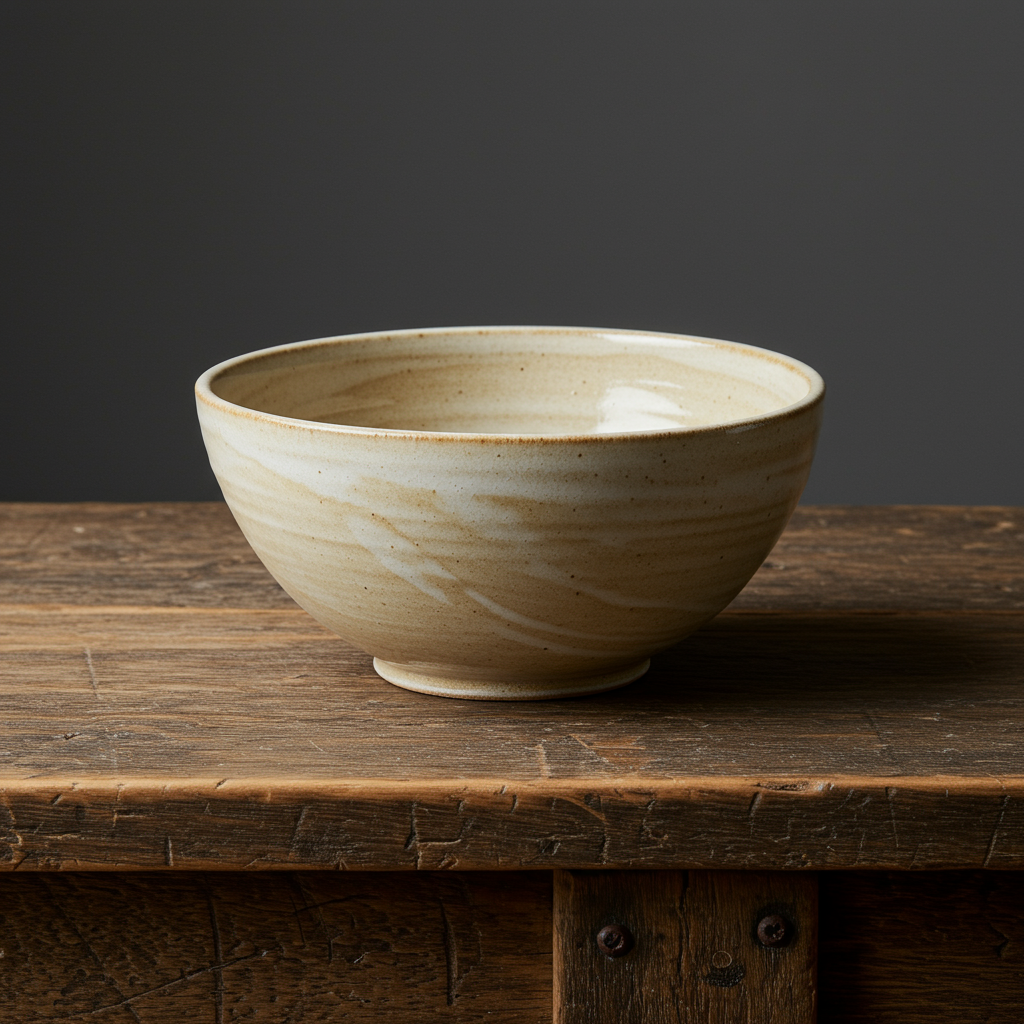

In [6]:
original_image = Image.from_file(
    location="empty-bowl-on-empty-table.png",
    mime_type="image/png"
)
original_image.show()

In [7]:
dest_filename = "empty-bowl-on-empty-table-copy.png"
original_image.save(dest_filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, dest_filename, dest_filename)

File empty-bowl-on-empty-table-copy.png uploaded to empty-bowl-on-empty-table-copy.png.


In [8]:
edit_model_name = "imagen-3.0-capability-001"

# Task 6. Use mask segmentation to create a neutral background
While the team wants many of the catalog images you have been asked to create to feel like the bowl is in a real setting, they also want a 'neutral' image in as simple a setting as possible. They ask if you can remove the table, as it has a lot of character on its own, for a more 'neutral' product shot.



In [9]:
original_image

Image(
  image_bytes=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00\x00\x00\x04\x00\x08\x02\x00\x00\x00\xf0\x7f\xbc\xd4\x00\x00\x00\x83zTXtRaw profile type iptc\x00\x00\x08\x99M\x8b;\x0e\xc20\x10\x05{\x9f"G\xd8\xdd\xbc\xfd\xa4\xa6\xa2\xa3\xe0\x02\xb6\xe3\x95\x90"\x05q\xff\x02...',
  mime_type='image/png'
)

In [11]:
# In this task, you will use your original_image again to create a product photo with a neutral background. The RawReferenceImage is provided for you below:

raw_ref_image = RawReferenceImage(
    reference_image=original_image,
    reference_id=0
)
raw_ref_image

RawReferenceImage(
  reference_id=0,
  reference_image=Image(
    image_bytes=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00\x00\x00\x04\x00\x08\x02\x00\x00\x00\xf0\x7f\xbc\xd4\x00\x00\x00\x83zTXtRaw profile type iptc\x00\x00\x08\x99M\x8b;\x0e\xc20\x10\x05{\x9f"G\xd8\xdd\xbc\xfd\xa4\xa6\xa2\xa3\xe0\x02\xb6\xe3\x95\x90"\x05q\xff\x02...',
    mime_type='image/png'
  ),
  reference_type='REFERENCE_TYPE_RAW'
)

In [12]:
# Create a MaskReferenceImage that will automatically mask out specific classes by their class ID. You can look up the segmentation class for a table in the class reference at the bottom of this lab. Use it to create a segmentation mask for the table:

# mask the 'table' using class id 67
#      reference table with class ids: https://github.com/GoogleCloudPlatform/generative-ai/blob/main/vision/getting-started/imagen3_editing.ipynb
mask_ref_image = MaskReferenceImage(
    # Fill in the appropriate configuration
    reference_id=1,
    reference_image=None,
    config=MaskReferenceConfig(
        mask_mode="MASK_MODE_SEMANTIC",
        segmentation_classes=[67],
        mask_dilation=0.1,
    ),
)
mask_ref_image

MaskReferenceImage(
  config=MaskReferenceConfig(
    mask_dilation=0.1,
    mask_mode=<MaskReferenceMode.MASK_MODE_SEMANTIC: 'MASK_MODE_SEMANTIC'>,
    segmentation_classes=[
      67,
    ]
  ),
  mask_image_config=MaskReferenceConfig(
    mask_dilation=0.1,
    mask_mode=<MaskReferenceMode.MASK_MODE_SEMANTIC: 'MASK_MODE_SEMANTIC'>,
    segmentation_classes=[
      67,
    ]
  ),
  reference_id=1,
  reference_type='REFERENCE_TYPE_MASK'
)

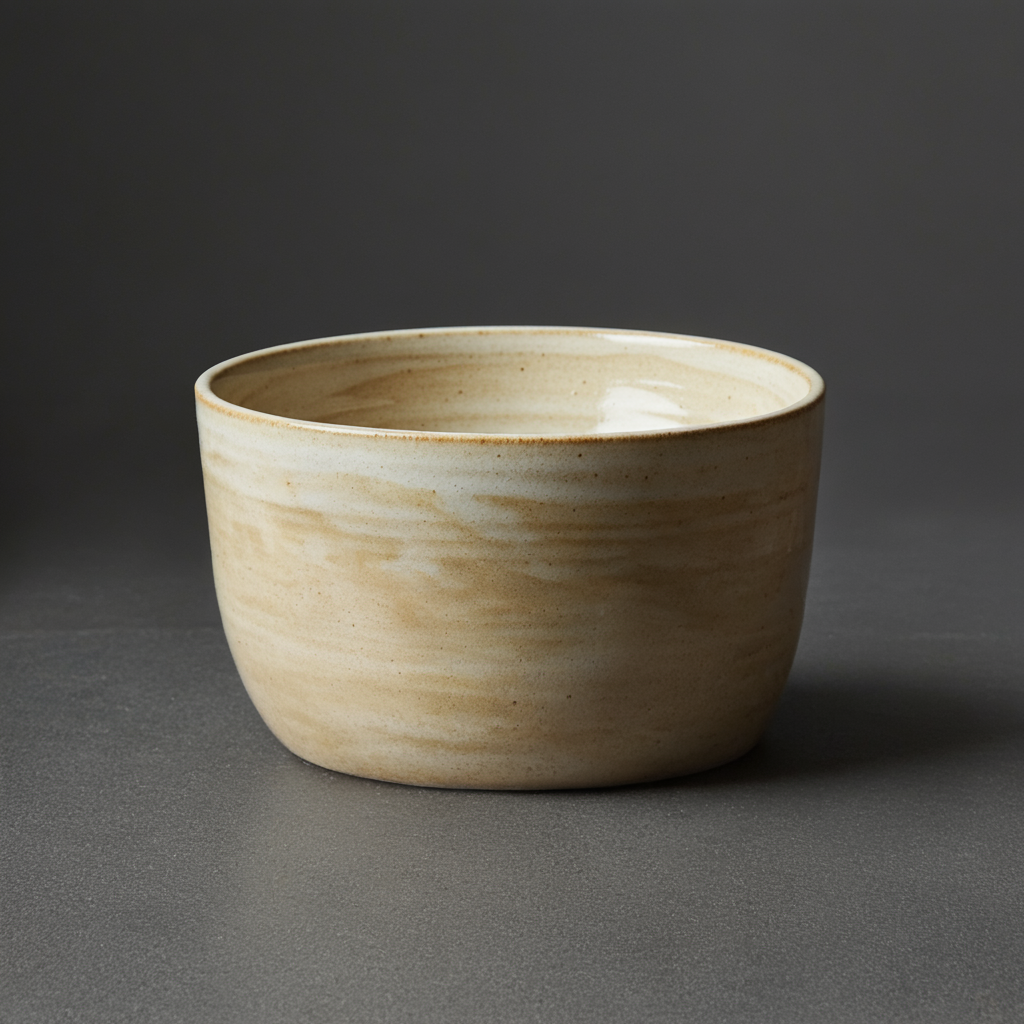

In [15]:
# Replace #ENTER_THE_CORRECT_EDIT_MODE in the code below with the correct edit mode to remove the table object detected by the mask segmentation. Run the code and make sure you see a result.

edit_prompt = ""
neutral_surface_image = client.models.edit_image(
    model=edit_model_name,
    prompt=edit_prompt,
    reference_images=[raw_ref_image, mask_ref_image],
    config=EditImageConfig(
        edit_mode= "EDIT_MODE_INPAINT_REMOVAL", #ENTER_THE_CORRECT_EDIT_MODE ,
        number_of_images=1,
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
    ),
)

neutral_surface_image.generated_images[0].image.show()

In [16]:
# Run the following code to save your neutral_surface_image locally and upload it to Cloud Storage:

filename = "bowl-on-neutral-surface.png"

neutral_surface_image.generated_images[0].image.save(filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, filename, filename)

File bowl-on-neutral-surface.png uploaded to bowl-on-neutral-surface.png.


# Task 7. Swap the background to put the product at a festive party
The team would also like to see the opposite: the bowl in a more fun, party-like environment.



In [17]:
original_image

Image(
  image_bytes=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00\x00\x00\x04\x00\x08\x02\x00\x00\x00\xf0\x7f\xbc\xd4\x00\x00\x00\x83zTXtRaw profile type iptc\x00\x00\x08\x99M\x8b;\x0e\xc20\x10\x05{\x9f"G\xd8\xdd\xbc\xfd\xa4\xa6\xa2\xa3\xe0\x02\xb6\xe3\x95\x90"\x05q\xff\x02...',
  mime_type='image/png'
)

In [18]:
# In this task, you will again use your original_image to create a product photo with a festive party background. The RawReferenceImage is the same as in the previous task:
raw_ref_image = RawReferenceImage(
    reference_image=original_image,
    reference_id=0
)


In [19]:
# Create a MaskReferenceImage that will automatically mask the background of the image:
mask_ref_image = MaskReferenceImage(
    # Fill in the appropriate configuration
    reference_id=1,
    reference_image=None,
    config=MaskReferenceConfig(mask_mode="MASK_MODE_BACKGROUND"),
)

mask_ref_image

MaskReferenceImage(
  config=MaskReferenceConfig(
    mask_mode=<MaskReferenceMode.MASK_MODE_BACKGROUND: 'MASK_MODE_BACKGROUND'>
  ),
  mask_image_config=MaskReferenceConfig(
    mask_mode=<MaskReferenceMode.MASK_MODE_BACKGROUND: 'MASK_MODE_BACKGROUND'>
  ),
  reference_id=1,
  reference_type='REFERENCE_TYPE_MASK'
)

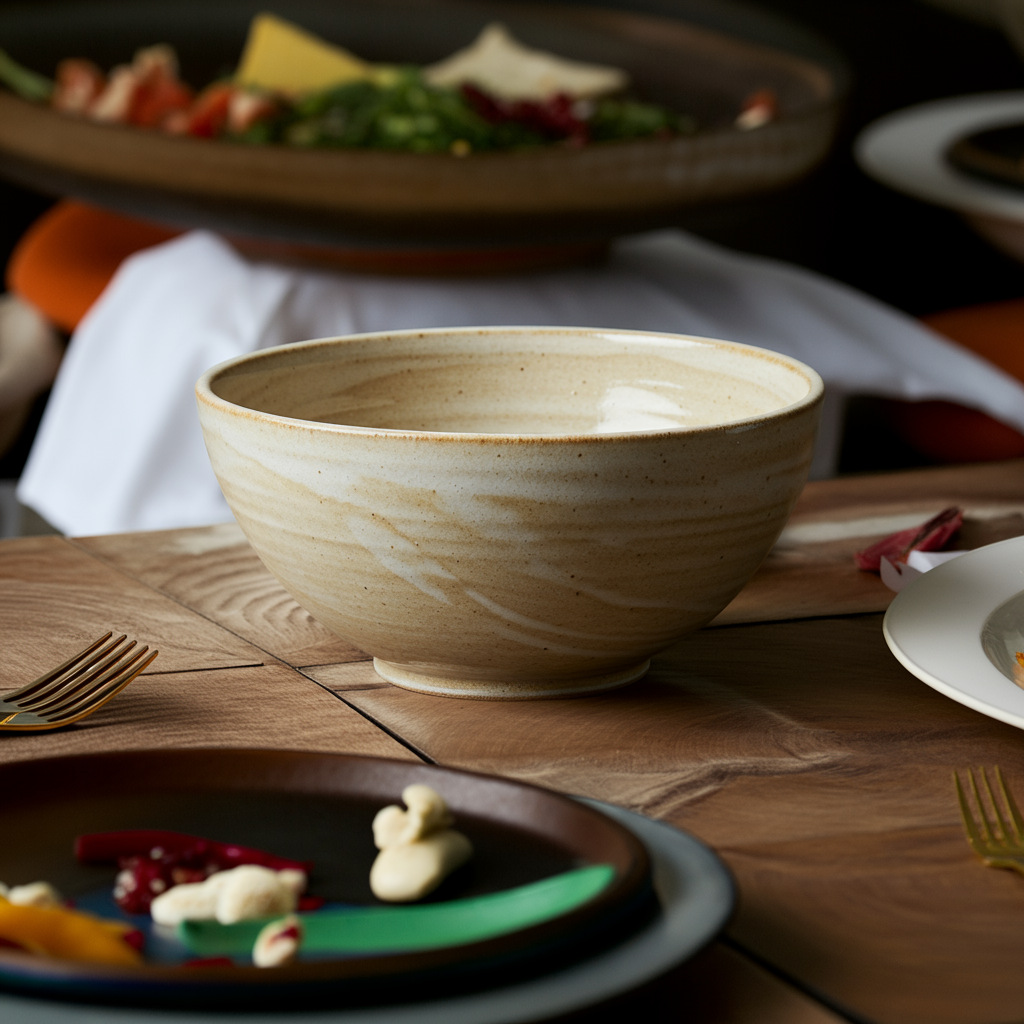

In [20]:
# Replace #ENTER_THE_CORRECT_EDIT_MODE in the code below with the correct edit mode to swap the background. Run the code and make sure you see a result.

edit_prompt = "A bowl on a table at a fun dinner party"
dinner_party_image = client.models.edit_image(
    model=edit_model_name,
    prompt=edit_prompt,
    reference_images=[raw_ref_image, mask_ref_image],
    config=EditImageConfig(
        edit_mode= "EDIT_MODE_BGSWAP", #ENTER_THE_CORRECT_EDIT_MODE ,
        number_of_images=1,
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
    ),
)

dinner_party_image.generated_images[0].image.show()

In [21]:
# Run the following code to save your dinner_party_image locally and upload it to Cloud Storage:

filename = "bowl-at-a-party.png"

dinner_party_image.generated_images[0].image.save(filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, filename, filename)

File bowl-at-a-party.png uploaded to bowl-at-a-party.png.
